Header

In [64]:
import cufinufft

ModuleNotFoundError: No module named 'cufinufft'

In [1]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt

import pysht
from pysht import get_geom

import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs


lmax, mmax = 1025, 1025
ll = np.arange(0,lmax)
geominfo = ('gl',{'lmax': lmax})
# geominfo = ('healpix',{'nside': 512})

solver = 'duccnufft'
backend = 'CPU'

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')

t = pysht.get_transformer(solver, backend)
t.set_geometry(geominfo)

# int(t.geom.nph[0]/2-1)


if solver in ['finufft']:
    defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
    print("defres.shape: {}".format(defres.shape))
elif solver in ['duccnufft']:
    defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
    print("defres.shape: {}".format(defres.shape))
elif solver == 'ducc':
    defres = t.synthesis_general(Tunl.copy(), dlm=dlm, mmax=lmax, spin=0, backwards=False)
    print("defres.shape: {}".format(defres.shape))

mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
deflection std is 2.53e+00 amin
build angles <- synthesis (GRAD_ONLY)
theta= [2.34274278e-03 5.37757223e-03 8.43032399e-03 ... 3.13316233e+00
 3.13621508e+00 3.13924991e+00] phi0= [0. 0. 0. ... 0. 0. 0.] nphi= [2160 2160 2160 ... 2160 2160 2160] ringstart= [      0    2160    4320 ... 2209680 2211840 2214000] deflect= [[-2.62084506e-04 -3.12370366e-04]
 [-2.62936270e-04 -3.10763304e-04]
 [-2.63782651e-04 -3.09154055e-04]
 ...
 [ 8.49111254e-04 -1.55261453e-05]
 [ 8.49108375e-04 -1.30818534e-05]
 [ 8.49097685e-04 -1.06368493e-05]] calc_rotation= True nthreads= 4
build_angles
U2nu:
  nthreads=4, grid=(2056x2058), oversampled grid=(3200x3200), supp=10, eps=1e-07
  npoints=2216160
  memory overhead: 0.00825584GB (index) + 0.152588GB (oversampled grid)

Total wall clock time for u2nu: 0.07138s
|
+- u2nu proper          : 88.81% (0.0634s)
|  |
|  +- interpolation        : 43.70% (0.0277s)
|  +- FFT                  : 37

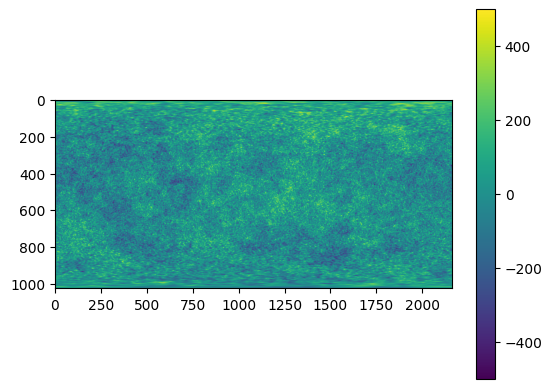

NameError: name 'tunlducc' is not defined

In [2]:
plt.imshow(defres.reshape(lmax+1,-1), vmin=-500, vmax=500)
plt.colorbar()
plt.show()

plt.imshow(tunlducc.reshape(lmax+1,-1), vmin=-500, vmax=500)
plt.colorbar()
plt.show()
plt.imshow(defres.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1), vmin=-80, vmax=80, label='finufft')
plt.colorbar()
plt.show()
plt.imshow(Tsky.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1), vmin=-80, vmax=80, label='ducc')
plt.colorbar()

# hp.mollview(defres, norm='hist')
# plt.colorbar()

In [54]:
phis = t.geom.rings2phi(t.geom, np.arange(len(t.geom.theta)))
thetas = np.array([th*np.ones(shape=t.geom.nph[0]) for th in t.geom.theta]).flatten()
map_dfs_shifted = np.fft.fftshift(map_dfs, axes=(0,1))

# tskyducc = defres.reshape(lmax+1,-1)# np.roll(defres.reshape(lmax+1,-1),int(t.geom.nph[0]/2+1), axis=1)

tunlducc = np.roll(t.synthesis(Tunl.copy(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0].reshape(lmax+1,-1),0, axis=1)
tskyducc = np.roll(defres.reshape(lmax+1,-1).copy(),int(t.geom.nph[0]/2-1), axis=1)

/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")


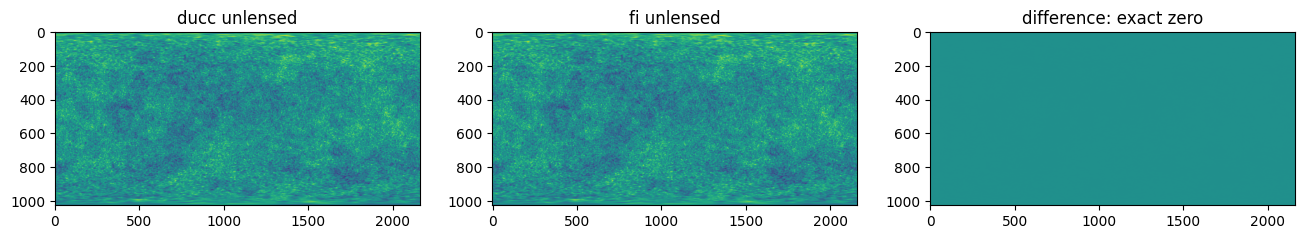

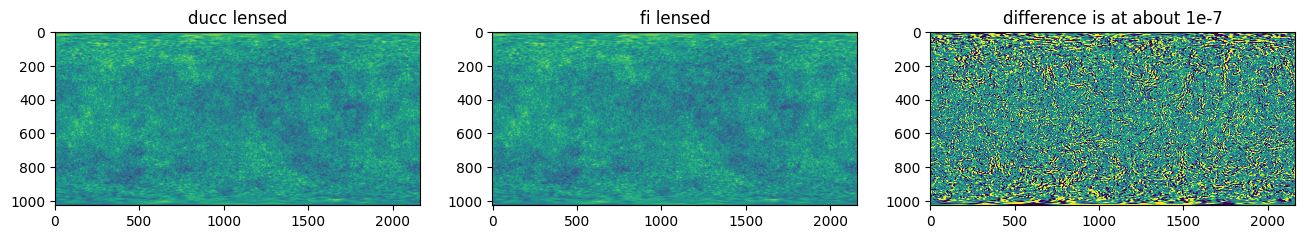

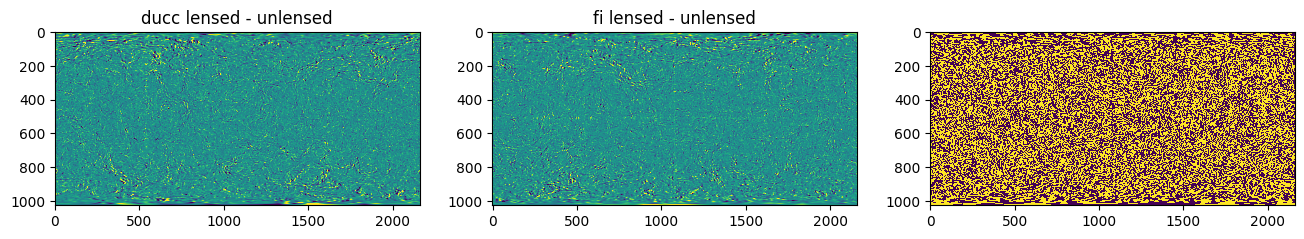

1.009 37982142.37072945


In [55]:
import numpy as np
import finufft
a = []
ffacs = np.arange(1.0091,1.01,0.2)
for ffac in ffacs:#,1e-7,1e-10]:
    tol = 1e-13
    f = map_dfs_shifted
    # f = np.ones_like(mapd_dfs_shifted)
    tunl_ = finufft.nufft2d2(x=phis, y=thetas.copy(), f=f.T, eps=tol, isign=1)
    Tskyfi_ = finufft.nufft2d2(x=ptg[:,1][::-1].copy(), y=ptg[:,0].copy(), f=f.T, eps=tol, isign=1)
    # Tskyfi_ = finufft.nufft2d2(x=ptg[:,0][::-1].copy(), y=ptg[:,1].copy(), f=f, eps=tol)
# int(t.geom.nph[0]/2+
    tunlfi = np.roll(np.real(tunl_).reshape(lmax+1,-1),0, axis=1)
    tskyfi = np.roll(np.real(Tskyfi_).reshape(lmax+1,-1),0, axis=1)
        
    # tunlfi = np.real(tunl_).reshape(lmax+1,-1)
    # tskyfi = np.real(Tskyfi_).reshape(lmax+1,-1)
    
    # restpl, restpu = 10, 150
    # resttl, resttu = 10, 150
    restpl, restpu = 0, 2160
    resttl, resttu = 0, 1026

    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow((tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[0].set_title('ducc unlensed')
    ax[1].imshow((tunlfi)[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[1].set_title('fi unlensed')
    ax[2].imshow((tunlducc.reshape(lmax+1,-1)-tunlfi)[resttl:resttu,restpl:restpu], vmin=-1e-7,vmax=1e-7)
    ax[2].set_title('difference: exact zero')
    plt.show()


    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow(tskyducc.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[0].set_title('ducc lensed')
    ax[1].imshow(tskyfi[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[1].set_title('fi lensed')
    ax[2].imshow((tskyfi.reshape(lmax+1,-1)-tskyducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu], vmin=-10,vmax=10)
    ax[2].set_title('difference is at about 1e-7')
    plt.show()


    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow((tskyducc.reshape(lmax+1,-1)[:,::-1]-tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu], vmin=-20,vmax=20)
    ax[0].set_title('ducc lensed - unlensed')
    ax[1].imshow((tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu][:,::-1]-tunlfi[resttl:resttu,restpl:restpu]), vmin=-20,vmax=20)
    ax[1].set_title('fi lensed - unlensed')
    ax[2].imshow((tskyducc.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu]-(tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu]-tunlfi[resttl:resttu,restpl:restpu]), vmin=-1e-6,vmax=1e-6)
    plt.show()
    a.append(np.sqrt(np.sum(np.abs((tskyfi.reshape(lmax+1,-1)[:,::-1]-tunlfi)[resttl:resttu,restpl:restpu]-((tskyducc.reshape(lmax+1,-1)[:,::-1]-tunlducc.reshape(lmax+1,-1)))[resttl:resttu,restpl:restpu]))**2))
    print("{:.3f}".format(ffac), np.sqrt(np.sum(np.abs((tskyfi.reshape(lmax+1,-1)-tunlfi)[resttl:resttu,restpl:restpu]-((tskyducc.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1)))[resttl:resttu,restpl:restpu]))**2))
    

# isign -1

/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}.

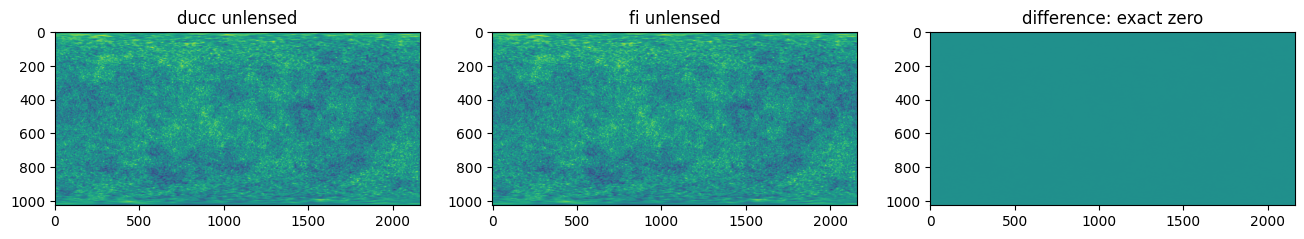

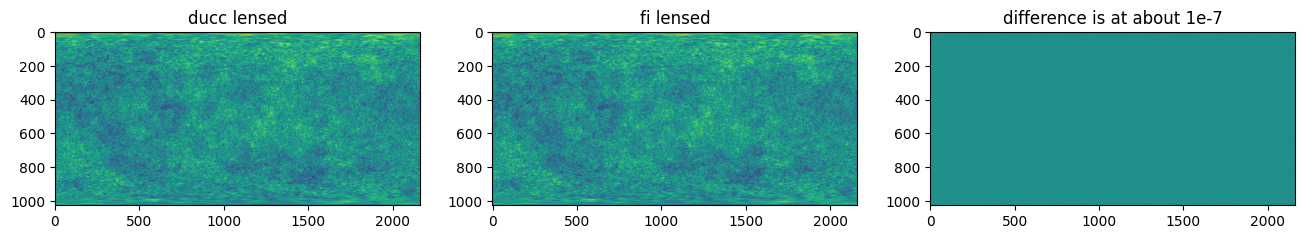

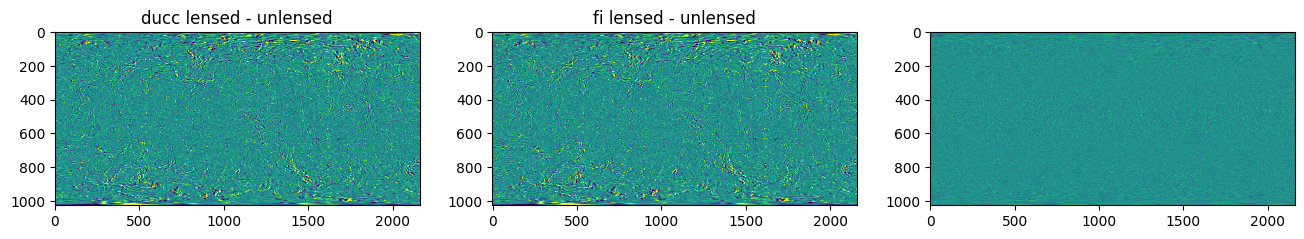

1.009 0.8785163779727465


In [10]:
"""
NEVER TOUCH THIS AGAIN..
"""

phis = t.geom.rings2phi(t.geom, np.arange(len(t.geom.theta)))
thetas = np.array([th*np.ones(shape=t.geom.nph[0]) for th in t.geom.theta]).flatten()
map_dfs_shifted = np.fft.fftshift(map_dfs, axes=(0,1))

# tskyducc = defres.reshape(lmax+1,-1)# np.roll(defres.reshape(lmax+1,-1),int(t.geom.nph[0]/2+1), axis=1)

tunlducc = np.roll(t.synthesis(Tunl.copy(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0].reshape(lmax+1,-1),int(t.geom.nph[0]/2-1), axis=1)
tskyducc = np.roll(defres.reshape(lmax+1,-1).copy(), 0, axis=1)

a = []
ffacs = np.arange(1.0091,1.01,0.2)
for ffac in ffacs:#,1e-7,1e-10]:
    tol = 1e-13
    f = map_dfs_shifted

    tunl_ = finufft.nufft2d2(x=phis[::-1], y=thetas.copy(), f=f.T, eps=tol)
    Tskyfi_ = finufft.nufft2d2(x=ptg[:,1].copy(), y=ptg[:,0].copy(), f=f.T, eps=tol)
    # Tskyfi_ = finufft.nufft2d2(x=ptg[:,0][::-1].copy(), y=ptg[:,1].copy(), f=f, eps=tol)
# int(t.geom.nph[0]/2+
    
    tunlfi = np.roll(np.real(tunl_).reshape(lmax+1,-1),0, axis=1)
    tskyfi = np.roll(np.real(Tskyfi_).reshape(lmax+1,-1),0, axis=1)
        
    # tunlfi = np.real(tunl_).reshape(lmax+1,-1)
    # tskyfi = np.real(Tskyfi_).reshape(lmax+1,-1)
    
    # restpl, restpu = 10, 150
    # resttl, resttu = 10, 150
    restpl, restpu = 0, 2160
    resttl, resttu = 0, 1026

    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow((tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[0].set_title('ducc unlensed')
    ax[1].imshow((tunlfi)[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[1].set_title('fi unlensed')
    ax[2].imshow((tunlducc.reshape(lmax+1,-1)-tunlfi)[resttl:resttu,restpl:restpu], vmin=-1e-8,vmax=1e-8)

    ax[2].set_title('difference: exact zero')
    plt.show()


    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow(tskyducc.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[0].set_title('ducc lensed')
    ax[1].imshow(tskyfi[resttl:resttu,restpl:restpu], vmin=-500,vmax=500)
    ax[1].set_title('fi lensed')
    ax[2].imshow(tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu]-tskyducc.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu],
                 vmin=-1,vmax=1)
    ax[2].set_title('difference is at about 1e-7')
    plt.show()


    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].imshow((tskyducc.reshape(lmax+1,-1)[:,::-1]-tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu], vmin=-20,vmax=20)
    ax[0].set_title('ducc lensed - unlensed')
    ax[1].imshow((tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu][:,::-1]-tunlfi[resttl:resttu,restpl:restpu]), vmin=-20,vmax=20)
    ax[1].set_title('fi lensed - unlensed')
    ax[2].imshow((tskyducc.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu]-(tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu]-tunlfi[resttl:resttu,restpl:restpu]), vmin=-1e-6,vmax=1e-6)
    plt.show()
    a.append(np.sqrt(np.sum(np.abs((tskyfi.reshape(lmax+1,-1)[:,::-1]-tunlfi)[resttl:resttu,restpl:restpu]-((tskyducc.reshape(lmax+1,-1)[:,::-1]-tunlducc.reshape(lmax+1,-1)))[resttl:resttu,restpl:restpu]))**2))
    print("{:.3f}".format(ffac), np.sqrt(np.sum(np.abs((tskyfi.reshape(lmax+1,-1)-tunlfi)[resttl:resttu,restpl:restpu]-((tskyducc.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1)))[resttl:resttu,restpl:restpu]))**2))
    

## healpix grid

In [57]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt

import pysht
from pysht import get_geom

import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

nside = 1024
lmax, mmax = 3*nside, 3*nside
ll = np.arange(0,lmax)
geominfo = ('healpix',{'nside': nside})
# geominfo = ('healpix',{'nside': 512})

solver = 'duccnufft'
backend = 'CPU'

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')


t = pysht.get_transformer(solver, backend)
t.set_geometry(geominfo)

# tunlducc = t.synthesis(Tunl.copy(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0].reshape(lmax+1,-1)
# tskyducc = np.roll(Tsky.reshape(lmax+1,-1).copy(),-1, axis=1)

tunlducc = t.synthesis(Tunl.copy(), spin=0, lmax=lmax, mmax=mmax, nthreads=4)[0]
tskyducc = Tsky.copy()

if solver in ['finufft']:
    defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
    print("defres.shape: {}".format(defres.shape))
elif solver in ['duccnufft']:
    defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
    print("defres.shape: {}".format(defres.shape))
elif solver == 'ducc':
    defres = t.synthesis_general(Tunl.copy(), dlm=dlm, mmax=lmax, spin=0, backwards=False)
    print("defres.shape: {}".format(defres.shape))

deflection std is 2.57e+00 amin
build angles <- synthesis (GRAD_ONLY)
theta= [7.97359963e-04 1.59472005e-03 2.39208040e-03 ... 3.13920057e+00
 3.13999793e+00 3.14079529e+00] phi0= [0.78539816 0.39269908 0.26179939 ... 0.26179939 0.39269908 0.78539816] nphi= [ 4  8 12 ... 12  8  4] ringstart= [       0        4       12 ... 12582888 12582900 12582908] deflect= [[-2.12545895e-04 -5.06732196e-04]
 [-4.39803609e-04  2.00827283e-04]
 [ 2.76885874e-04  6.02504841e-04]
 ...
 [-6.73169686e-05 -2.86805820e-04]
 [ 2.35344394e-04 -2.36352910e-05]
 [-3.03523342e-05  2.53022799e-04]] calc_rotation= True nthreads= 4
build_angles
U2nu:
  nthreads=4, grid=(6158x6160), oversampled grid=(8064x8064), supp=12, eps=1.000000000000000e-07
  npoints=12582912
  memory overhead: 4.687500000000000e-02GB (index) + 9.689941406250000e-01GB (oversampled grid)

Total wall clock time for u2nu: 0.5348s
|
+- u2nu proper          : 89.83% (0.4804s)
|  |
|  +- interpolation        : 43.96% (0.2112s)
|  +- FFT             

In [58]:
phis = t.geom.rings2phi(t.geom, np.arange(len(t.geom.theta)))
thetas = np.hstack([th*np.ones(shape=t.geom.nph[thi]) for thi,th in enumerate(t.geom.theta)])
print(phis.shape, thetas.shape)

map_dfs_shifted = np.fft.fftshift(map_dfs, axes=(0,1))
tskyducc = defres# np.roll(defres.reshape(lmax+1,-1),int(t.geom.nph[0]/2+1), axis=1)

(12582912,) (12582912,)


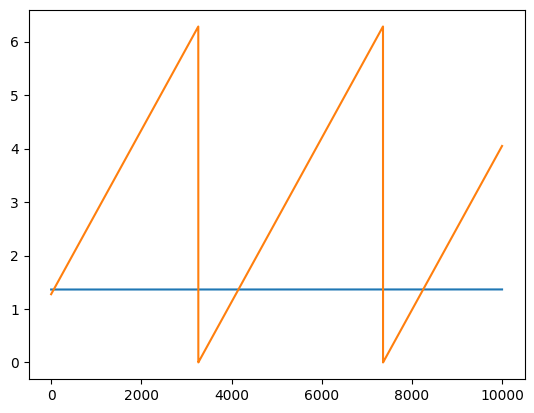

In [59]:
plt.plot(thetas[5000000:5010000])
plt.plot(phis[5000000:5010000])

healpix

/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/Users/sbelkner/.pyenv/versions/3.11.7/lib/python3.11/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")


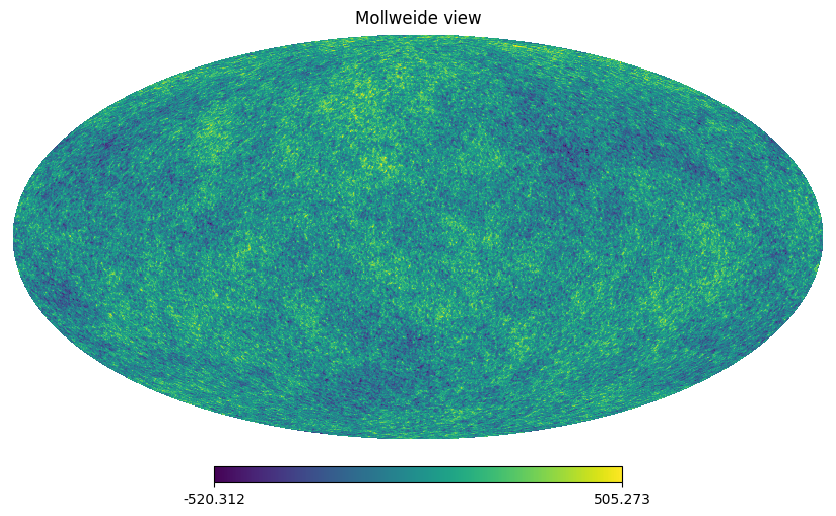

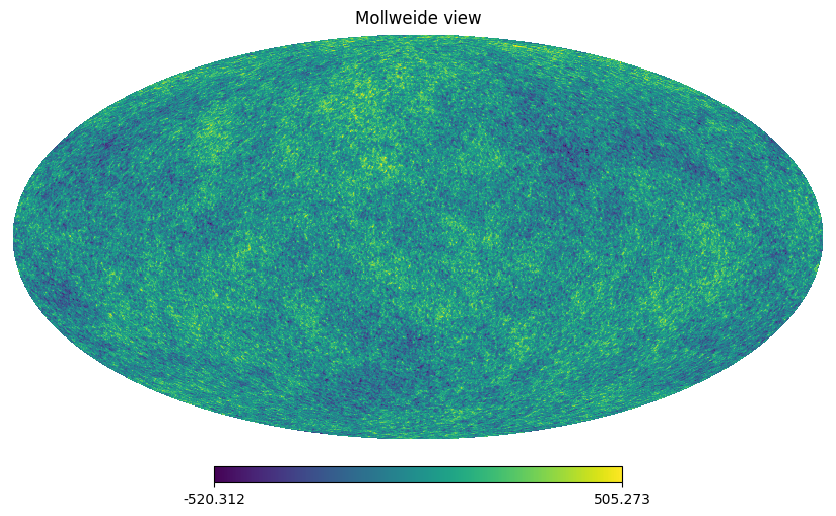

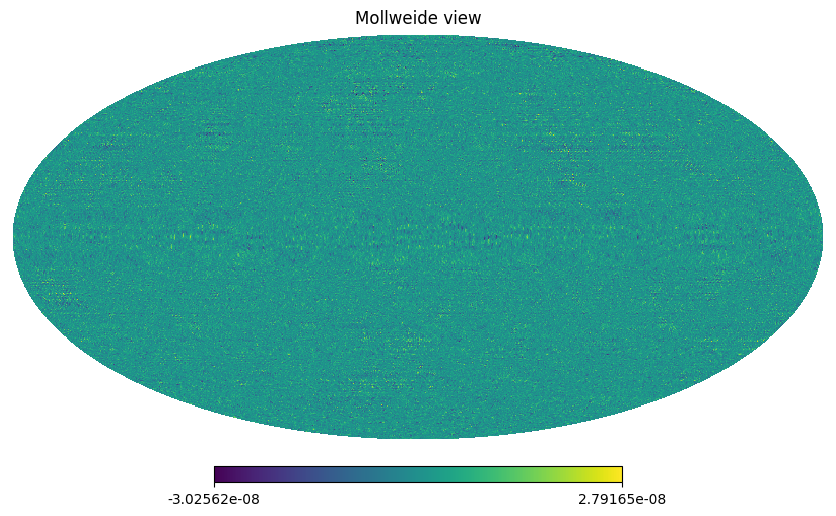

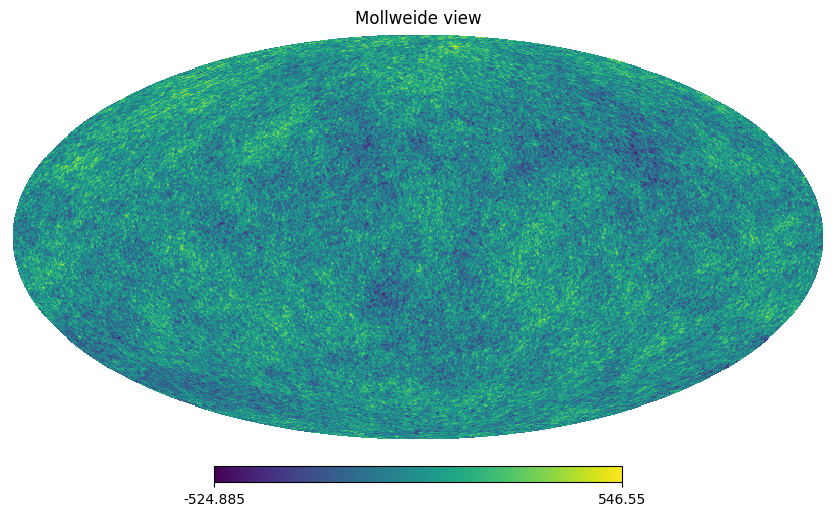

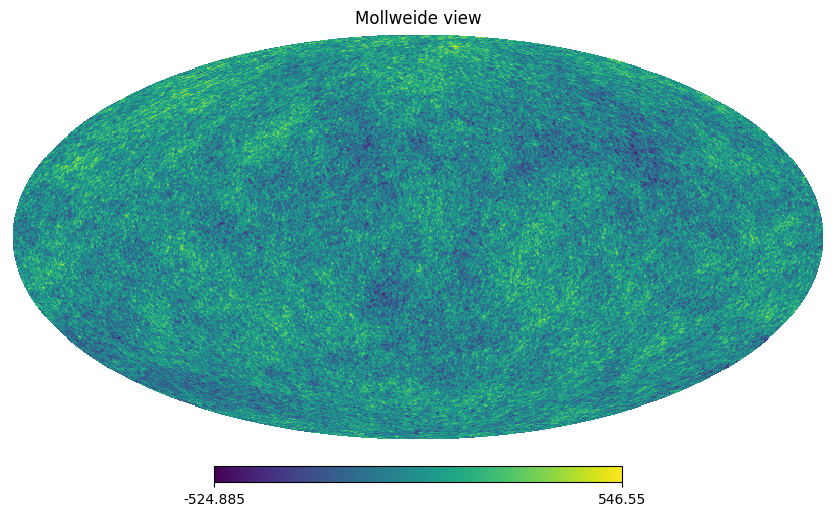

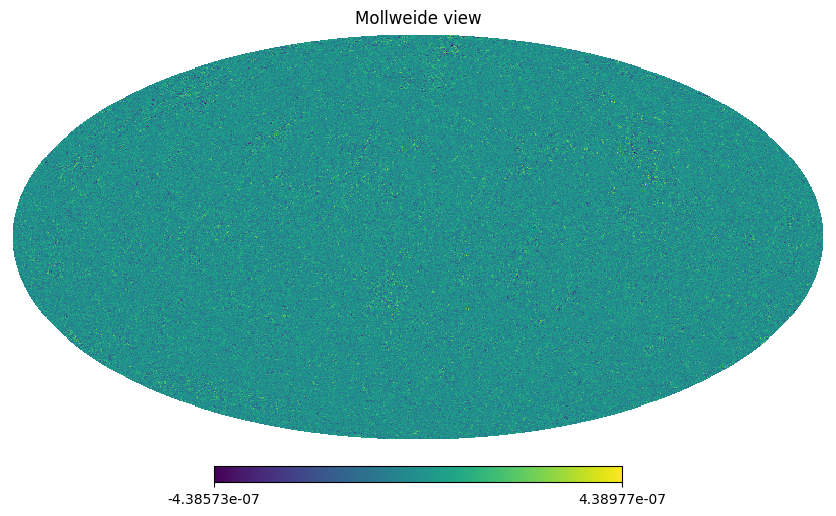

AttributeError: 'Axes' object has no attribute 'mollview'

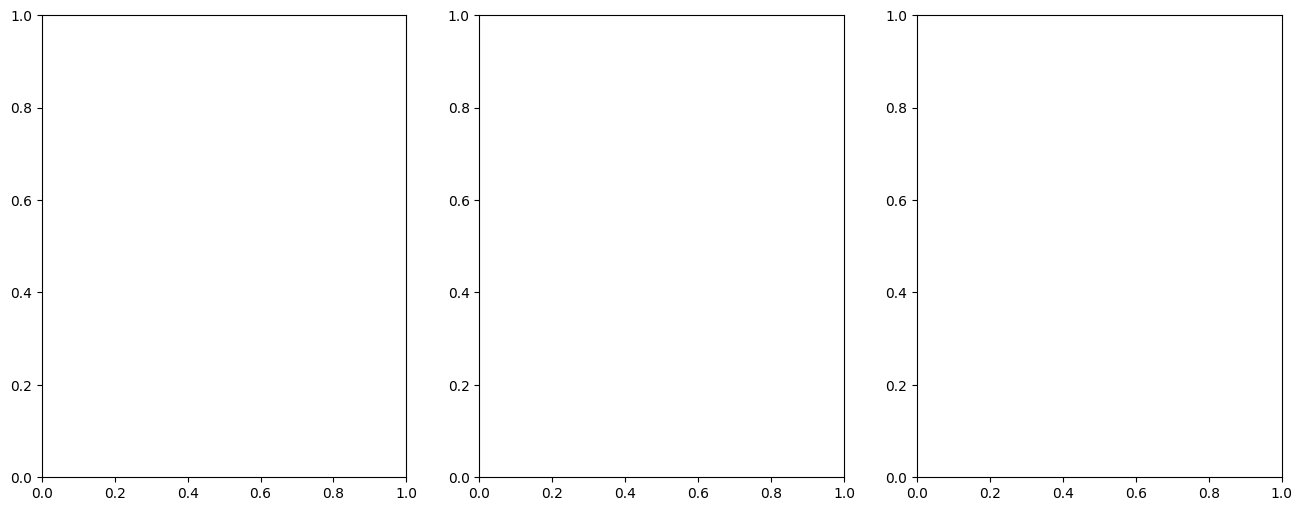

In [63]:
import numpy as np
import finufft
a = []
ffacs = np.arange(1.0091,1.01,0.2)
for ffac in ffacs:#,1e-7,1e-10]:
    tol = 1e-10
    f = map_dfs_shifted
    # f = np.ones_like(mapd_dfs_shifted)
    tunl_ = finufft.nufft2d2(x=phis, y=thetas.copy(), f=f.T, eps=tol, isign=1)
    Tskyfi_ = finufft.nufft2d2(x=ptg[:,1].copy(), y=ptg[:,0].copy(), f=f.T, eps=tol, isign=-1)
    # Tskyfi_ = finufft.nufft2d2(x=ptg[:,0][::-1].copy(), y=ptg[:,1].copy(), f=f, eps=tol)

    tunlfi = np.real(tunl_)
    tskyfi = np.real(Tskyfi_)
    # tunlfi = np.real(tunl_).reshape(lmax+1,-1)
    # tskyfi = np.real(Tskyfi_).reshape(lmax+1,-1)
    
    restpl, restpu = 400, 1200
    resttl, resttu = 1050, 1200
    restpl, restpu = 0, 2160
    resttl, resttu = 0, 1026

    hp.mollview(tunlducc)
    # hp.set_title('ducc unlensed')
    hp.mollview(tunlfi)
    # hp.set_title('fi unlensed')
    hp.mollview((tunlducc-tunlfi))
    # ax[2].set_title('difference: exact zero')
    plt.show()



    hp.mollview(tskyducc)
    # ax[0].set_title('ducc lensed')
    hp.mollview(tskyfi)
    # ax[1].set_title('fi lensed')
    hp.mollview(tskyfi-tskyducc, cbar=True)

    # ax[2].set_title('difference is at about 1e-7')
    plt.show()


    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].mollview((tskyducc.reshape(lmax+1,-1)[:,::-1]-tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu], vmin=-20,vmax=20)
    ax[0].set_title('ducc lensed - unlensed')
    ax[1].mollview((tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu][:,::-1]-tunlfi[resttl:resttu,restpl:restpu]), vmin=-20,vmax=20)
    ax[1].set_title('fi lensed - unlensed')
    ax[2].mollview((tskyducc.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1))[resttl:resttu,restpl:restpu]-(tskyfi.reshape(lmax+1,-1)[resttl:resttu,restpl:restpu]-tunlfi[resttl:resttu,restpl:restpu]), vmin=-1e-6,vmax=1e-6)
    plt.show()
    a.append(np.sqrt(np.sum(np.abs((tskyfi.reshape(lmax+1,-1)[:,::-1]-tunlfi)[resttl:resttu,restpl:restpu]-((tskyducc.reshape(lmax+1,-1)[:,::-1]-tunlducc.reshape(lmax+1,-1)))[resttl:resttu,restpl:restpu]))**2))
    print("{:.3f}".format(ffac), np.sqrt(np.sum(np.abs((tskyfi.reshape(lmax+1,-1)-tunlfi)[resttl:resttu,restpl:restpu]-((tskyducc.reshape(lmax+1,-1)-tunlducc.reshape(lmax+1,-1)))[resttl:resttu,restpl:restpu]))**2))
    

Text(0, 0.5, 'node hours')

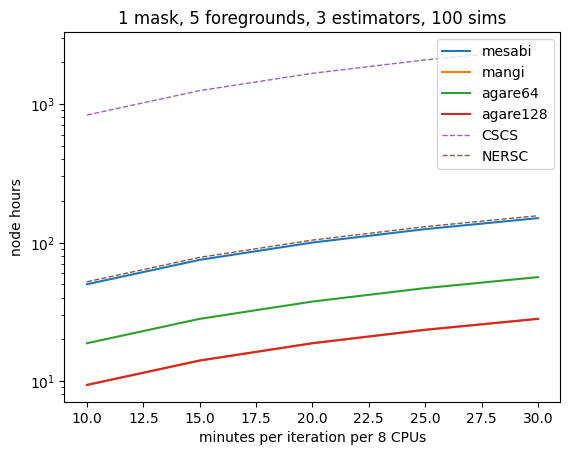

In [60]:
duration = [10,35]
machine = {'mesabi': 24, "mangi": 128, "agare64":64, "agare128":128}
def f(dur, itermax, nsim, nset, ncore):
    return 1/60 * dur*itermax*nsim*nset*8/(ncore)

plt.plot(np.arange(*duration,5), [f(n, 10, 10, 1*3*3, machine['mesabi']) for n in np.arange(*duration,5)], label= 'mesabi')
plt.plot(np.arange(*duration,5), [f(n, 10, 10, 1*3*3, machine['mangi']) for n in np.arange(*duration,5)], label= 'mangi')
plt.plot(np.arange(*duration,5), [f(n, 10, 10, 1*3*3, machine['agare64']) for n in np.arange(*duration,5)], label= 'agare64')
plt.plot(np.arange(*duration,5), [f(n, 10, 10, 1*3*3, machine['agare128']) for n in np.arange(*duration,5)], label= 'agare128')

plt.plot(np.arange(*duration,5), [f(n, 10, 100, 5*3, 24) for n in np.arange(*duration,5)], label='CSCS', ls='--', lw=1)
plt.plot(np.arange(*duration,5), [f(n, 10, 100, 5*2, 256) for n in np.arange(*duration,5)], label='NERSC', ls='--', lw=1)
plt.legend()
plt.yscale('log')
plt.xlabel("minutes per iteration per 8 CPUs")
plt.title("1 mask, 5 foregrounds, 3 estimators, 100 sims")
plt.ylabel("node hours")